In [8]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from IPython.display import display

from disruption_survival_analysis.sweep_config import create_experiment_groups, get_experiments


from disruption_survival_analysis.plot_experiments import plot_true_alarm_rates_vs_thresholds, plot_false_alarm_rates_vs_thresholds, plot_warning_times_vs_thresholds
from disruption_survival_analysis.plot_experiments import plot_true_alarm_rates_vs_false_alarm_rates, plot_missed_alarm_rates_vs_false_alarm_rates, plot_avg_warning_times_vs_false_alarm_rates


#device = 'synthetic'
#dataset_path = 'test'
devices = ['cmod']
#dataset_paths = ['preliminary_dataset_no_ufo']
#dataset = 'sql_all_no_ufo'
dataset='preliminary_dataset_no_ufo'
dataset_paths = [dataset, f"{dataset}/stack_6"]

# models, alarms, metrics, and minimum warning times to use
models = ['cph', 'dsm', 'rf', 'km']
#models = ['rf']
alarms = ['sthr']
metrics = ['auroc']
min_warning_times = [0.01, 0.05, 0.1]

# Load models and create experiments
experiment_groups = create_experiment_groups(devices, dataset_paths, models, alarms, metrics, min_warning_times)

# C

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/cph_sthr_auroc_10ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/cph_sthr_auroc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/cph_sthr_auroc_50ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/cph_sthr_auroc_50ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/cph_sthr_auroc_100ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/cph_sthr_auroc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/dsm_sthr_auroc_10ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_uf

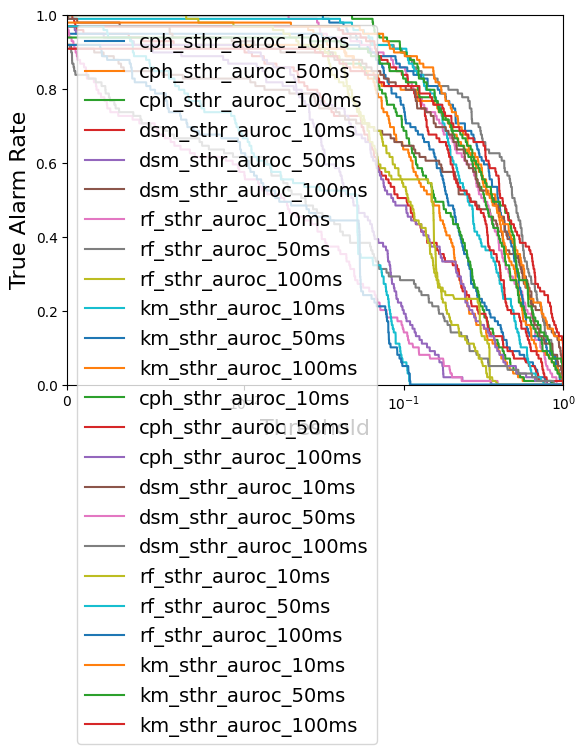

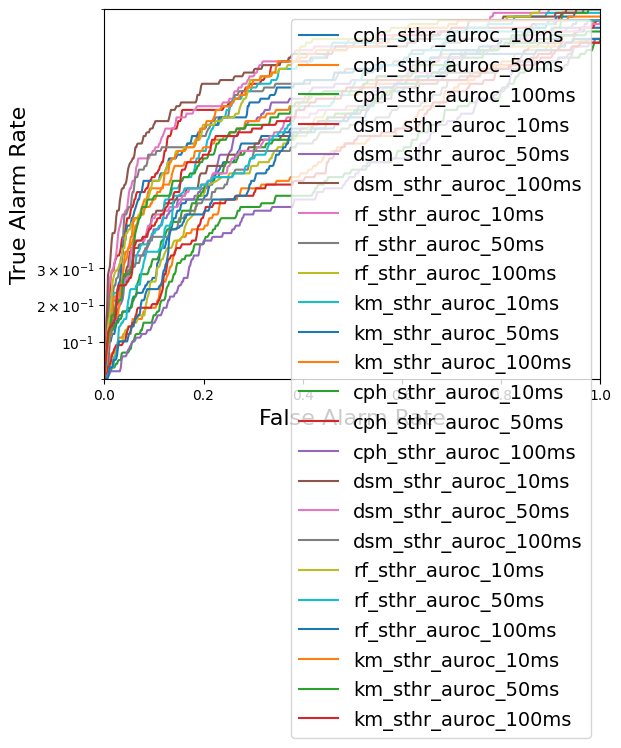

In [9]:
# Pre-compute and cache all values for all experiments
experiment_list = get_experiments(experiment_groups, ['auroc'])
plot_true_alarm_rates_vs_thresholds(experiment_list)
plot_true_alarm_rates_vs_false_alarm_rates(experiment_list)

## Threshold Plots



In [9]:
# Save experiment_groups to disk
import dill
with open(f"experiment_groups_{dataset}.pkl", 'wb') as f:
    dill.dump(experiment_groups, f)

In [3]:
# Load experiment_groups from disk
import dill
with open(f"experiment_groups_{dataset}.pkl", 'rb') as f:
    experiment_groups = dill.load(f)

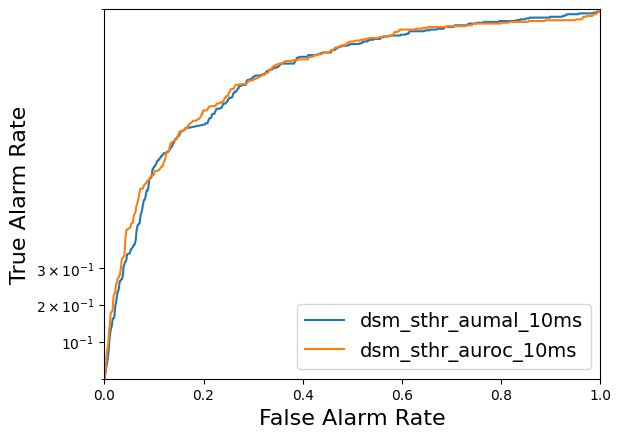

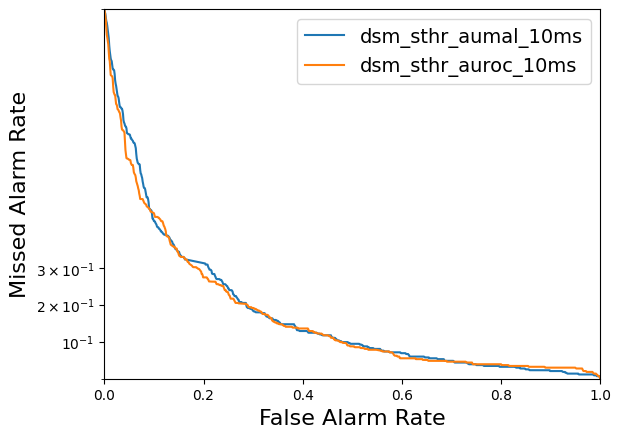

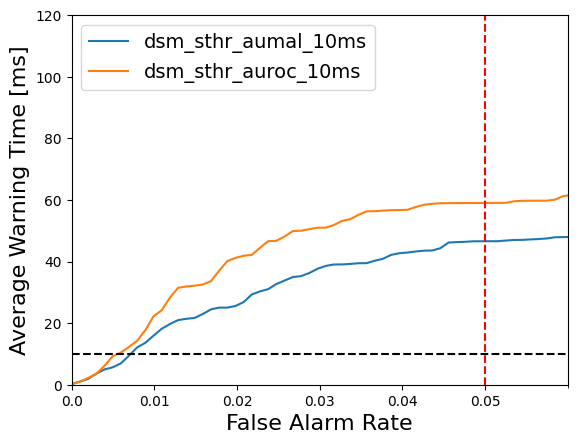

AUROC:	 0.8237577217568832
AUMAL:	 -1.021803900966191
AUROC:	 0.8288058498916338
AUMAL:	 -0.9983355870708333


In [7]:
required_warning_time = 0.01
experiment_list = get_experiments(experiment_groups, 
                                  [dataset, 'dsm', 'aumal', required_warning_time],
                                  [dataset, 'dsm', 'auroc', required_warning_time])

plot_true_alarm_rates_vs_false_alarm_rates(experiment_list)
plot_missed_alarm_rates_vs_false_alarm_rates(experiment_list)
plot_avg_warning_times_vs_false_alarm_rates(experiment_list, required_warning_time)
#plot_true_alarm_rates_vs_thresholds(experiment_list)
#plot_false_alarm_rates_vs_thresholds(experiment_list)
#plot_warning_times_vs_thresholds(experiment_list)

for experiment in experiment_list:
    aumal = experiment.evaluate_metric('aumal')
    auroc = experiment.evaluate_metric('auroc')
    print(f"AUROC:\t {auroc}")
    print(f"AUMAL:\t {aumal}")

## ROC Curve

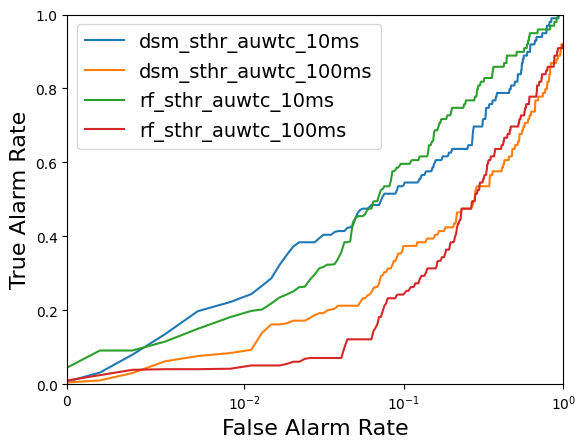

## Area Under Warning Time Curve



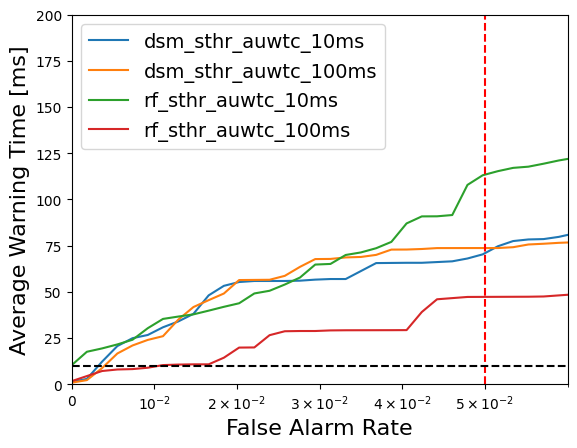